## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

## Steps
1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform
5. Detect lane lines
6. Determine the lane curvature

## Import Packages, Initial Values and Defined Functions

In [46]:
# Import and functions
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mping
import os
% matplotlib inline

# Initial values
lanefound = False
left_fit, right_fit = None, None


# Define a function that calculates the matrix and distortion coefficients from the collected objpoints 
# and imgpoints and the image size.
def calibrate(img_size, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

# Define a function that undistorts the image from the calibrated matrix and the distortion coefficients.
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


# Define a function that applies Sobel x or y, then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh= (0,255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here is using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function that applies Sobel x and y, then computes the magnitude of the gradient and 
# applies a threshold
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that applies Sobel x and y, then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that applies the color thresholds
def color_thresh(img):
    # Give the thrshold for white and yellow color lanes
    thresh_lw = (220, 255)
    thresh_hy = (20, 30)
    thresh_ly = (0, 220)
    thresh_sy = (120, 255)
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    # apply a threshold, and create a binary image result
    binary_output = np.zeros_like(l)
    binary_output[((l>=thresh_lw[0])&(l<=thresh_lw[1]))
     | ((h >= thresh_hy[0])&(h <= thresh_hy[1])&(l>=thresh_ly[0])&(l<=thresh_ly[1])
     & (s>=thresh_sy[0]) & (s<=thresh_sy[1]))]=1
    return binary_output

# Define a function that unwarp the lanes
def corners_unwarp(img, src, dst):
    (w, h) = (img.shape[1], img.shape[0])
    # Get M, the trnasform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image
    warped = cv2.warpPerspective(img, M, (w, h), flags = cv2.INTER_LINEAR)
    return warped, M, Minv



# Define a function that slides windows and fits a polynomial for the first image, that lef_fit and right_fit are empty,
# and skips the sliding for the rest images.
def slidingwindows(binary_warped):
    
    global lanefound, left_fit, right_fit
    # Set the width of the windows +/- margin
    margin = 100
    #Set minimum number of pixels found to recenter window
    minpix = 50
    
    if not lanefound:
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        lanefound = True

    else:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(leftx)>minpix and len(lefty)>minpix and len(rightx)>50 and len(righty)>50:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        prev_fit = (left_fit, right_fit)
    else:
        (left_fit, right_fit) = prev_fit
            

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    left_pixX = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    right_pixX = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    car_center = ((left_pixX + right_pixX)/2 - 650) * xm_per_pix
    
    return left_fit, right_fit, left_curverad, right_curverad, car_center, left_lane_inds, right_lane_inds
    

def draw_lane(img, binary_warped, left_fit, right_fit, Minv, left_curverad, right_curverad, car_center):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((left_line_pts, right_line_pts))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([pts]), (0,255,0))
    cv2.polylines(window_img, np.int32([left_line_pts]), isClosed = False, color=(255, 0, 255), thickness = 15)
    cv2.polylines(window_img, np.int32([right_line_pts]), isClosed = False, color=(0, 255, 255), thickness = 15)

    # Warp the drawn image back to the original image space
    (w, h) = (img.shape[1], img.shape[0])
    inv_warped = cv2.warpPerspective(window_img, Minv, (w,h))

    result = cv2.addWeighted(img, 1, inv_warped, 0.5, 0)
    # Write text on each image
    cv2.putText(result, 'Radius: Left= %.2fm' % left_curverad + ', Right= %.2fm' % right_curverad, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    if car_center <0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(car_center), text),(20,80),cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
                

    return result


## Step 1 Camera Calibration
Use the images in the cameral_cal folder to collect the objpoints and imgpoints for camera calibration.

In [47]:
# Preprocess - Calibration
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Directory to store the corners found images
cf_images_dir = './output_images/cf_images/'
if not os.path.exists(cf_images_dir):
    os.makedirs(cf_images_dir)

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname) # cv2.imread() for BGR image. matlotlib.image.imread() for RGB image
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners. corners is a list of the points
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # Store the images with drawn corners
        cv2.imwrite('./output_images/cf_images/cf_'+fname.split('/')[-1], img)

## Step 2 Distortion Correction
Use the objpoints and imgpoints to undistort the image from the camera.

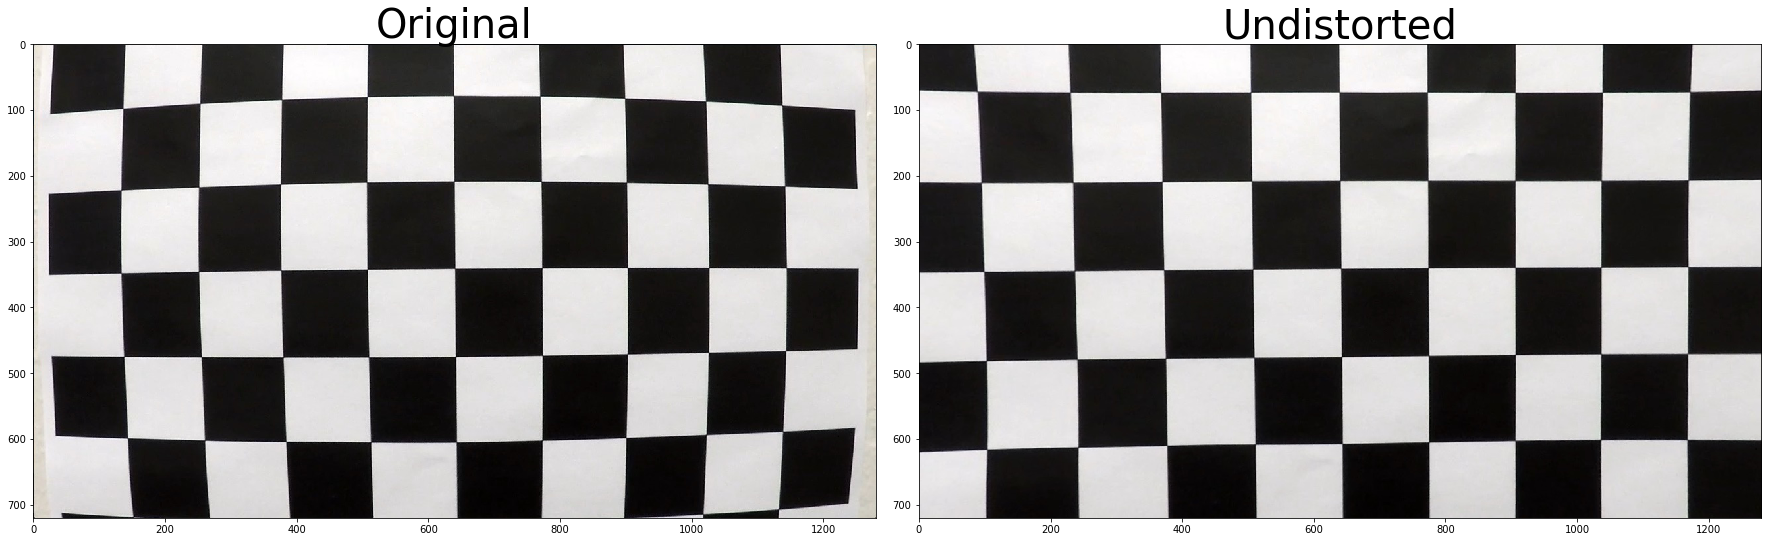

In [48]:
# Read in the image as RGB
cal_image = mping.imread('./camera_cal/calibration1.jpg')
(w, h) = cal_image.shape[1::-1]
mtx, dist = calibrate((w,h), objpoints, imgpoints)
undist = undistort(cal_image, mtx, dist)

# Display the original image and the undistorted image
# Display the images


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cal_image)
ax1.set_title('Original', fontsize=40)

ax2.imshow(undist)
ax2.set_title('Undistorted', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/undistorted1.jpg')

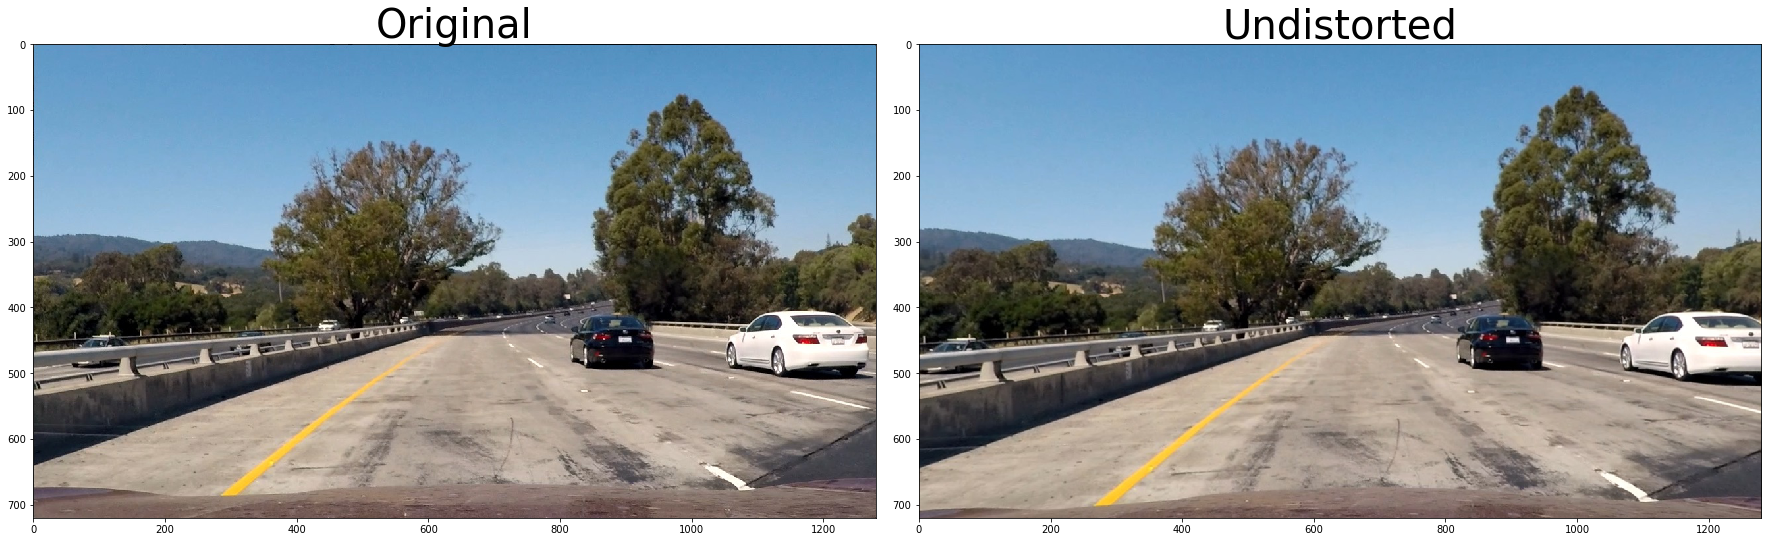

In [49]:
# Read in the image as RGB
image = mping.imread('./test_images/test1.jpg')
(w, h) = image.shape[1::-1]
mtx, dist = calibrate((w,h), objpoints, imgpoints)
undist = undistort(image, mtx, dist)

# Display the original image and the undistorted image
# Display the images


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original', fontsize=40)

ax2.imshow(undist)
ax2.set_title('Undistorted', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/undistorted2.jpg')

## Step 3 Color/Gradient Threshold
Apply color/gradient threshold to the image for better lanes detection

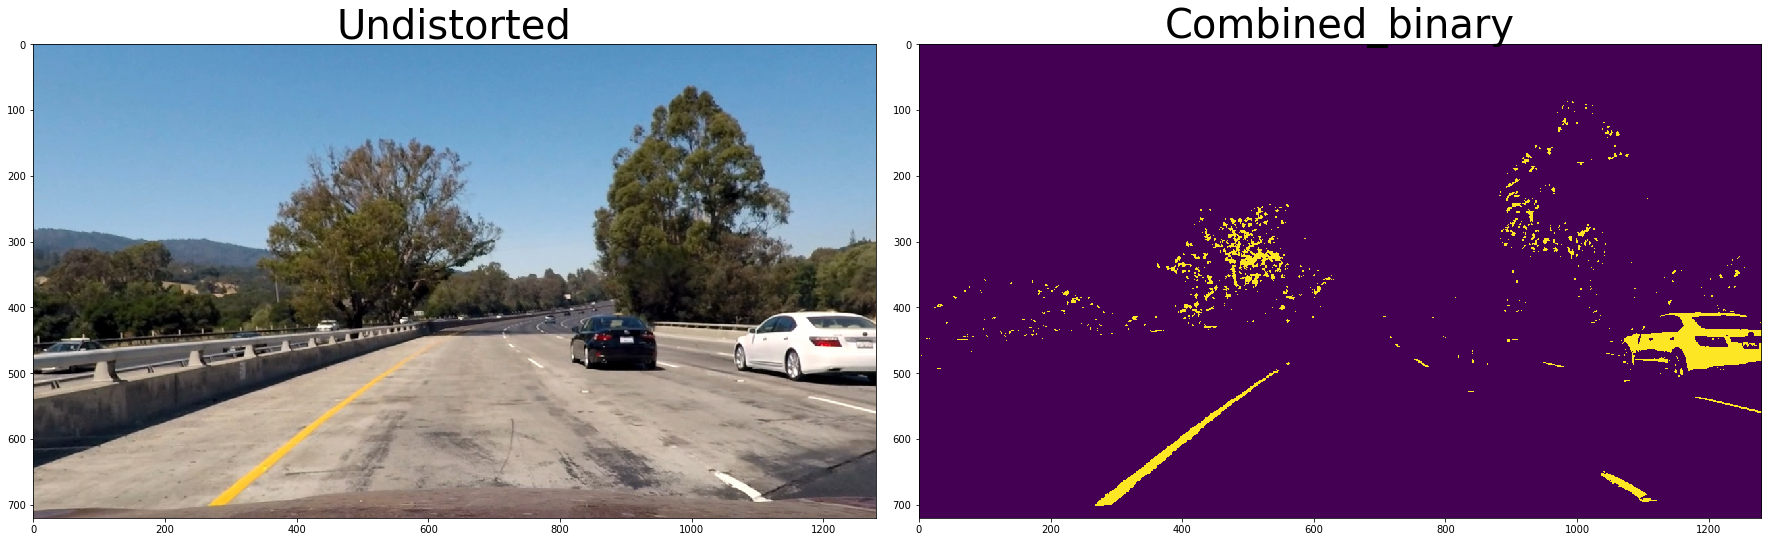

In [50]:

# Apply color threshold
combined_binary = color_thresh(undist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('Undistorted', fontsize=40)

ax2.imshow(combined_binary)
ax2.set_title('Combined_binary', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/color_thresh.jpg')

## Step 4 Perspective Transform
Get a birdeye view of the lane image.

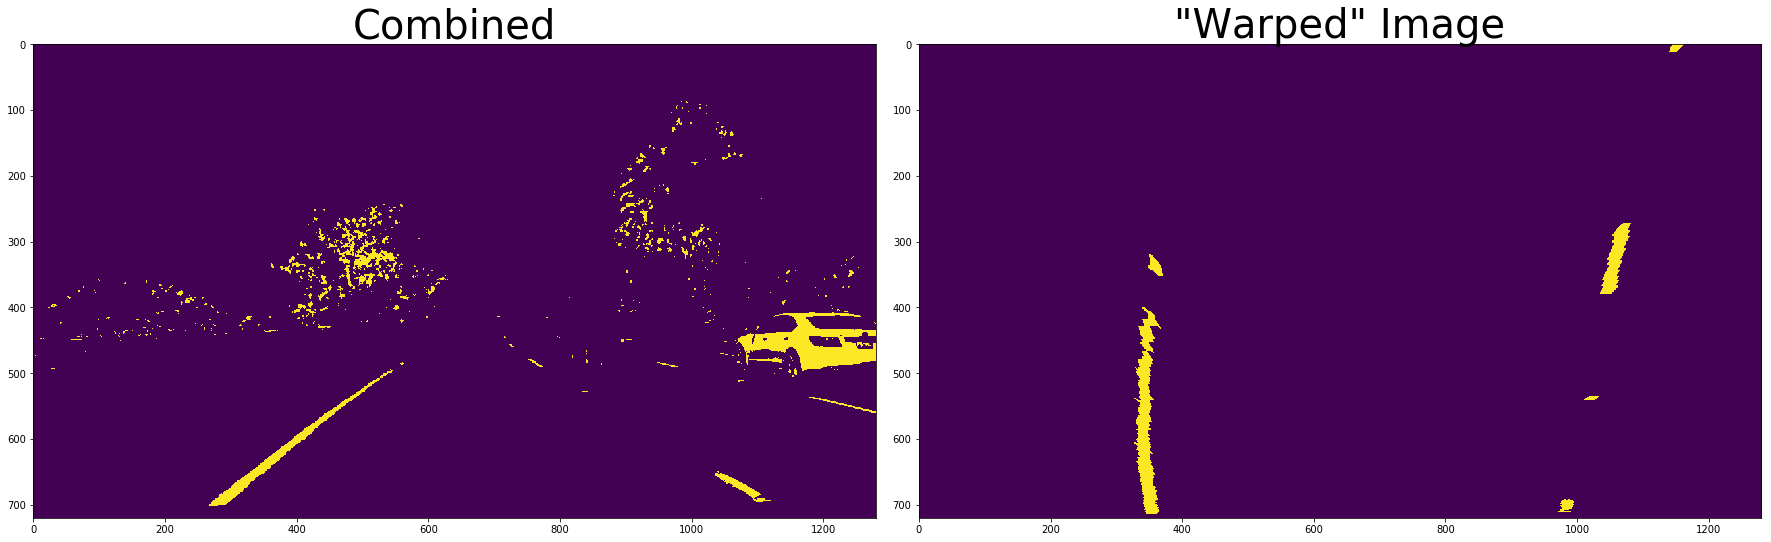

In [51]:
(w, h) = (combined_binary.shape[1], combined_binary.shape[0])

src = np.float32(
    [[(w / 2) - 55, h / 2 + 100],
    [((w / 6) - 10), h],
    [(w * 5 / 6) + 60, h],
    [(w / 2 + 55), h / 2 + 100]])
dst = np.float32(
    [[(w / 4), 0],
    [(w / 4), h],
    [(w * 3 / 4), h],
    [(w * 3 / 4), 0]])

warped, M, Minv = corners_unwarp(combined_binary, src, dst)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined_binary)
ax1.set_title('Combined', fontsize=40)

ax2.imshow(warped)
ax2.set_title("\"Warped\" Image", fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/perspective_transform.jpg')

## Step 5 Detect Lane Lines and Lane Curvature

Left Radii = 408.44m
Right Radii = 1315.31m
Distance from Center = 0.09m


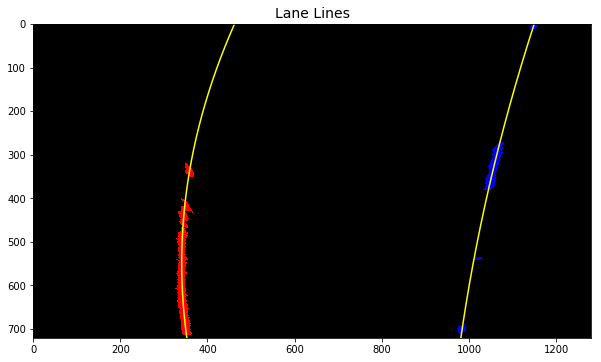

In [52]:
left_fit, right_fit, left_curverad, right_curverad, car_center, left_lane_inds, right_lane_inds=slidingwindows(warped)

# Create an image to draw on and an image to show the selection window
lanelines_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(lanelines_img)
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

lanelines_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
lanelines_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(10,7))
plt.imshow(lanelines_img)
plt.title("Lane Lines", fontsize = 14)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('./output_images/lane_lines.jpg')

print("Left Radii = %.2fm" % left_curverad)
print("Right Radii = %.2fm" % right_curverad)
print("Distance from Center = %.2fm" % car_center)

## Step 6 Draw Lanes

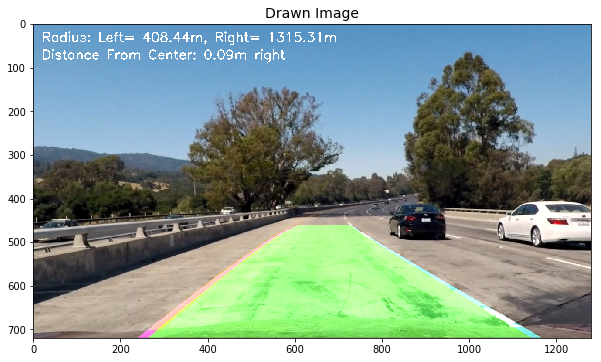

In [53]:
# Draw the lanes
out_img = draw_lane(undist, warped, left_fit, right_fit, Minv,left_curverad, right_curverad, car_center)

plt.figure(figsize=(10,7))
plt.imshow(out_img)
plt.title("Drawn Image", fontsize = 14)
plt.savefig('./output_images/drawn_lanes.jpg')

## Apply the full process on one test image

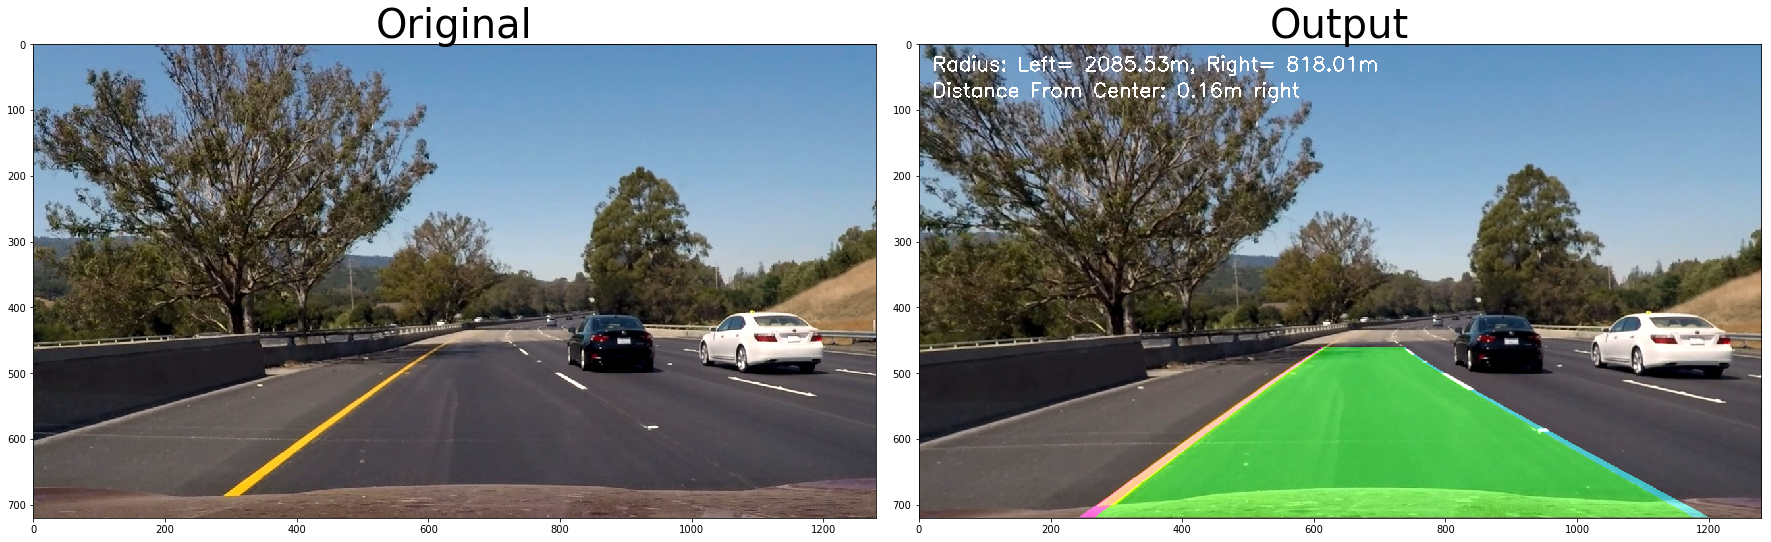

In [59]:
## Apply the full Process on image test1
lanefound = False

# Read in an image as RGB
image = mping.imread('./test_images/test1.jpg')

# Get image size
(w, h) = image.shape[1::-1]
# Get the mtx, dist from the calibration points and image
mtx, dist = calibrate((w,h), objpoints, imgpoints)
# Undistort the image
undist = undistort(image, mtx, dist)
# Apply color thresholds
combined_binary = color_thresh(undist)

# Warp the combined_binary image
src = np.float32(
    [[(w / 2) - 55, h / 2 + 100],
    [((w / 6) - 10), h],
    [(w * 5 / 6) + 60, h],
    [(w / 2 + 55), h / 2 + 100]])
dst = np.float32(
    [[(w / 4), 0],
    [(w / 4), h],
    [(w * 3 / 4), h],
    [(w * 3 / 4), 0]])

warped, M, Minv = corners_unwarp(combined_binary, src, dst)
# Detect the lanes and measure the curvature
left_fit, right_fit, left_curverad, right_curverad, car_center,left_lane_inds, right_lane_inds= slidingwindows(warped)

# Draw the lanes
out_img = draw_lane(undist, warped, left_fit, right_fit, Minv,left_curverad, right_curverad, car_center)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original', fontsize=40)

ax2.imshow(out_img)
ax2.set_title("Output", fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/drawn_test1.jpg')

## Create Pipeline

In [41]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
lanefound = False

In [42]:

def pipeline(img):
    global lanefound
    global left_fit
    global right_fit

    # Get image size
    (w,h) = img.shape[1::-1]
    # Get the mtx, dist from the calibration points and image
    mtx, dist = calibrate((w,h), objpoints, imgpoints)
    # Undistort the image
    undist = undistort(img, mtx, dist)
    # Apply color and gradient thresholds
    combined_binary = color_thresh(undist)
    # Warp the combined_binary image
    src = np.float32(
        [[(w / 2) - 55, h / 2 + 100],
        [((w / 6) - 10), h],
        [(w * 5 / 6) + 60, h],
        [(w / 2 + 55), h / 2 + 100]])
    dst = np.float32(
        [[(w / 4), 0],
        [(w / 4), h],
        [(w * 3 / 4), h],
        [(w * 3 / 4), 0]])

    warped, M, Minv = corners_unwarp(combined_binary, src, dst)
    # Detect the lanes and measure the curvature
    left_fit,right_fit,left_curverad,right_curverad,car_center,left_lane_inds,right_lane_inds= slidingwindows(warped)

    # Draw the lanes
    out_img = draw_lane(undist, warped, left_fit, right_fit, Minv,left_curverad, right_curverad, car_center)

    return out_img

In [43]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncommentFei the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [12:07<00:00,  1.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 12min 27s, sys: 9.36 s, total: 12min 36s
Wall time: 12min 8s


In [45]:
HTML("""
<video width="960" height="540" controls>Fei
  <source src="{0}">
</video>
""".format(white_output))